In [1]:
# !pip3 install tensorboardX
# !pip3 install torchvision

In [2]:
# from google.colab import files

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm

from tensorboardX import SummaryWriter
import torchvision.utils as vutils

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# %load_ext tensorboard.notebook

In [4]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 40
plt.rcParams['axes.titlesize']=36
plt.rcParams['axes.labelsize']=24
plt.rcParams['figure.figsize'] = (24.0, 12.0)
plt.rcParams['font.size'] = 40

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
device

device(type='cpu')

# Data

In [7]:
def align(k, window = 5):
    k = np.asarray(k)
    length = k.shape[0]
    for i in range(0, length, window):
        k[i:i + window] = k[i:i + window]*0 + k[i]
    
    
    return k

# def GeneratorOfTimeSeries(n = 100, m = 16384):
def GeneratorOfTimeSeries(n = 60, m = 16384):
    X = np.ones([m, n])*np.linspace(start = 0, stop = 0.1, num = n)
    T1 = []
    T2 = []
    for x in X:
        k = np.random.randint(low = 10, high = 200, size = n)
        A = np.random.randn(n)
        r = np.random.randint(10, 30)*0+n
        k = align(k, r)
        A = align(A, r)
        epsilon = 0.1*A*np.random.randn(n)*0
        T1.append((A*np.sin(k*x) + epsilon))
        T2.append((A*np.sin(k*x) + epsilon))
        
    T1 = np.asarray(T1)
    T2 = np.asarray(T2)
    return X, np.reshape(T1, [T1.shape[0], T1.shape[1], 1]), np.reshape(T2, [T2.shape[0], T2.shape[1], 1])

  
class TimeSeries(Dataset):
    def __init__(self, X, Y, device = 'cpu'):
        super(TimeSeries, self).__init__()
        self.X = torch.FloatTensor(X).to(device)
        self.Y = torch.FloatTensor(Y).to(device)
        self.len = X.shape[0]

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [8]:
step, X_train, Y_train = GeneratorOfTimeSeries(n = 10, m = 64)
step, X_test, Y_test = GeneratorOfTimeSeries(n = 10, m = 64)

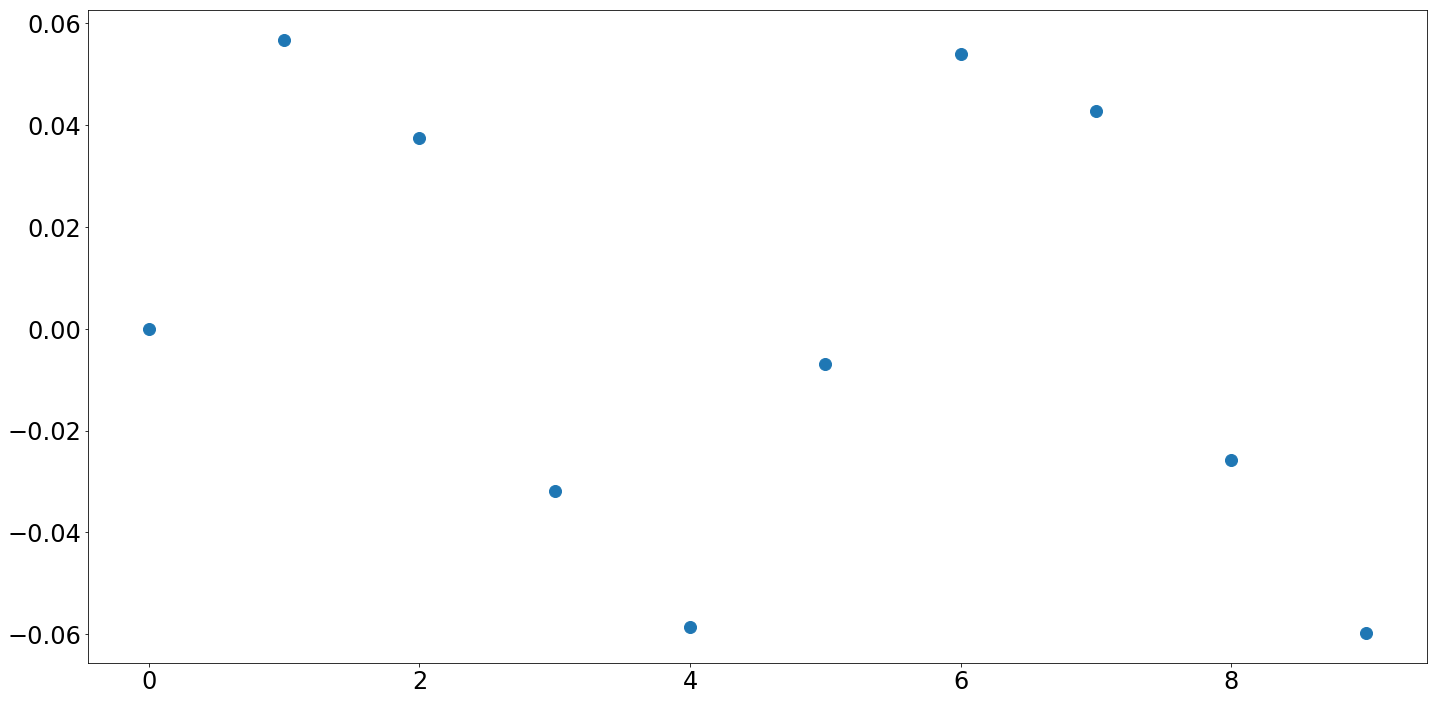

In [9]:
plt.plot(Y_train[0], 'o')

# Define Attention

In [10]:
class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()

    def get_scores(self, e, h):
        """
        e has a shape [batch_size, time_len_in_e, dim_e]
        h has a shape [batch_size, time_len_in_h, dim_h]
        Returns matrix of scores with shape [batch_size, time_len_in_h, time_len_in_e].
        """
        raise NotImplementedError()                

    def forward(self, e, h):
        """
        e has a shape [batch_size, time_len_in_e, dim_e]
        h has a shape [batch_size, time_len_in_h, dim_h]     
        
        result has a shape [batch_size, time_len_in_h, dim_e]
        alpha has a shape [batch_size, time_len_in_h, time_len_in_e]
        
        """
        scores = self.get_scores(e, h)
        alphas = F.softmax(scores, 2)
        result = torch.bmm(alphas, e)
        return result, alphas
    
class AdditiveAttention(Attention):
    def __init__(self, dim_e, dim_h, hidden_dim, device = 'cpu'):
        """
        dim_e      - hidden dimension of encoder
        dim_h      - hidden dimension of decoder
        hidden_dim        - hidden dimension of attention
        """
        super(AdditiveAttention, self).__init__()
        
        self.dim_e = dim_e
        self.dim_h = dim_h
        self.hidden_dim = hidden_dim
        
        self.W1 = nn.Linear(dim_e, hidden_dim, bias=False)
        self.W2 = nn.Linear(dim_h, hidden_dim, bias=False)
        self.w3 = nn.Linear(hidden_dim, 1, bias=False)
        self.to(device)

    def get_scores(self, e, h):
        """
        e has a shape [batch_size, time_len_in_e, dim_e]
        h has a shape [batch_size, time_len_in_h, dim_h]
        Returns matrix of scores with shape [batch_size, time_len_in_h, time_len_in_e].
        
        """
        f = self.W1(e).view(e.shape[0], 1, e.shape[1], -1)
        q = self.W2(h).view(h.shape[0], h.shape[1], 1, -1)
        a = torch.tanh(f + q)
        result = self.w3(a)[:, :, :, 0]
        return result
    
    
class MultiplicativeAttention(Attention):
    def __init__(self):
        super(MultiplicativeAttention, self).__init__()

    def get_scores(self, e, h):
        """
        e has a shape [batch_size, time_len_in_e, dim_e]
        h has a shape [batch_size, time_len_in_h, dim_h]
        Returns matrix of scores with shape [batch_size, time_len_in_h, time_len_in_e].
        """
        return torch.bmm(h, e.transpose(1, 2))

# Define seq2seq

In [11]:
class seq2seq(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, a_hidden_dim = None, num_layers=2, bidirectional = False, device = 'cpu'):
        super(seq2seq, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.device = device
        
        self.num_direction = int(bidirectional + 1)
        
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers, bidirectional = bidirectional)
        self.decoder = nn.LSTM(output_dim + self.num_direction*hidden_dim, hidden_dim, num_layers, bidirectional = bidirectional)
        self.linear = nn.Linear(self.num_direction*hidden_dim, output_dim)
        if a_hidden_dim is not None:
            self.attention = AdditiveAttention(self.num_direction*hidden_dim, self.num_direction*hidden_dim, a_hidden_dim, device = device)
        else:
            self.attention = MultiplicativeAttention()
      
        self.h = None
        self.c = None
        self.e = None
        self.d = None
      
        self.to(device)
       
    def encode(self, input):
        """
        input data:
            input has a shape [batch_size, time_len_e, input_dim]
        
        return data:
            None
        """
        input = torch.transpose(input, 0, 1)
        encoder_out, (encoder_h, encoder_c) = self.encoder(input)
        
        self.h = encoder_h
        self.c = encoder_c
        self.d = encoder_out[-1].unsqueeze(0)
        self.e = torch.transpose(encoder_out, 0, 1)
        return
      
    def decode(self, input):
        """
        input data:
            input has a shape [batch_size, 1, output_dim]
        
        return data:
            output has a shape [batch_size, 1, output_dim]
            alphas has a shape [batch_size, 1, time_len_e]
        """
        self.d = torch.transpose(self.d, 0, 1)
        
        contex, alphas = self.attention(self.e, self.d)
        contex = torch.transpose(contex, 0, 1)
        
        input = torch.cat((input, contex), dim = 2)
        self.d, (self.h, self.c) = self.decoder(input, (self.h, self.c))
        output = self.linear(self.d)
        
        return output, alphas
        
        
    def forward(self, input, max_len = 50):
        """
        input data:
            input has a shape [batch_size, time_len_e, input_dim]
            max_len is a maximum of generative sentence
        
        return data:
            decoder_out has a shape [batch_size, max_len, output_dim]
    
        """
        answer = torch.zeros(1, input.shape[0], self.output_dim).to(self.device)
        decoder_out = torch.zeros(max_len, input.shape[0], self.output_dim).to(self.device)
        
        self.encode(input)
        
        for i in range(max_len):
            answer, alphas = self.decode(answer)
            decoder_out[i] = answer[0]
        
        return torch.transpose(decoder_out, 0, 1)

    def get_attention(self, input, max_len = 50):
        """
        input data:
            input has a shape [batch_size, time_len_e, input_dim]
            max_len is a maximum of generative sentence
        
        return data:
            decoder_out has a shape [batch_size, max_len, output_dim]
            alphas has a shape [batch_size, max_len, time_len_in_e]
    
        """
        answer = torch.zeros(1, input.shape[0], self.output_dim).to(self.device)
        decoder_out = torch.zeros(max_len, input.shape[0], self.output_dim).to(self.device)
        alphas = torch.zeros(input.shape[0], max_len, input.shape[1])
        
        self.encode(input)

        for i in range(max_len):
            answer, alpha = self.decode(answer)
            
            alphas[:, i, :] = alpha[:,0,:] 
            decoder_out[i] = answer[0]
        
        return torch.transpose(decoder_out, 0, 1), alphas

# Train model

In [12]:
class callback():
    def __init__(self, writer, X, Y, delimeter = 100, device = 'cpu'):
        self.step = 0
        self.writer = writer
        self.delimeter = delimeter
        
        self.X_data_att = torch.FloatTensor(X).to(device)
        self.Y_data_att = torch.FloatTensor(Y).to(device)
        
        
      
    def forward(self, model, loss):
        self.step += 1
        self.writer.add_scalar('LSTM/scalar', loss.cpu().data.numpy(), self.step)
        
        if self.step % self.delimeter == 0:
            res, alphas = model.get_attention(self.X_data_att, max_len = self.Y_data_att.shape[1])

            fig = plt.figure()
            plt.plot(np.reshape(self.Y_data_att.cpu().data.numpy(), [-1]), 'o')
            plt.plot(np.reshape(res.cpu().data.numpy(), [-1]), 'o')
            self.writer.add_figure('LSTM/TimeSeries', fig, self.step)

            fig = plt.figure()
            plt.imshow(alphas[0, :, :].cpu().data.numpy())
            plt.colorbar()
            self.writer.add_figure('LSTM/Attention', fig, self.step)
            
    def __call__(self, model, loss):
        return self.forward(model, loss)

In [13]:
def train_on_batch(model, x_batch, y_batch, optimizer, loss_function):
    """
    x_batch has a shape [batch_size, time_len_in, input_dim]
    y_batch has a shape [batch_size, time_len_out, output_dim]
    """
    model.zero_grad()
    output = model.forward(x_batch, max_len = y_batch.shape[1])
    loss = loss_function(output, y_batch)
    loss.backward()

    optimizer.step()

    return loss

In [14]:
def train_epoch(train_generator, model, loss_function, optimizer, callback = None):
    model.train()
    loss = torch.zeros(1).to(str(model.device))
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        loss = train_on_batch(model, batch_of_x, batch_of_y, optimizer, loss_function)
        if callback is not None:
            callback(model, loss)
    return

In [15]:
def trainer(count_of_epoch, 
            batch_size, 
            dataset,
            model, 
            loss_function,
            optimizer,
            lr = 0.001,
            callback = None
           ):

    optima = optimizer(model.parameters(), lr = lr)
    
    for it in tqdm(range(count_of_epoch)):

        batch_generator = DataLoader(dataset = dataset, batch_size=batch_size)
        
        train_epoch(train_generator = batch_generator, model = model, loss_function = loss_function, optimizer = optima, callback=callback)

    return
        

# Define model

In [16]:
loss_fuction = torch.nn.MSELoss()
optimizer = torch.optim.Adam

dataset = TimeSeries(X_train, Y_train, device = device)

In [17]:
model = seq2seq(input_dim = 1, 
                hidden_dim = 50, 
                output_dim = 1, 
                a_hidden_dim = None,
                num_layers = 1, 
                device = device)

In [18]:
# writer = SummaryWriter(log_dir = '/tmp/log')

writer = SummaryWriter()

call = callback(writer, X_test[:1], Y_test[:1], delimeter = 100, device = device)

In [19]:
# %tensorboard --logdir /tmp/log

In [20]:
trainer(count_of_epoch = 10,
        batch_size = 64,
        dataset = dataset,
        model = model,
        loss_function = loss_fuction,
        optimizer = optimizer,
        lr = 0.001,
        callback = call
       )

100%|██████████| 10/10 [00:00<00:00, 43.68it/s]


In [21]:
# torch.save(model.state_dict(), '/tmp/log/model.pt')

In [22]:
# model.load_state_dict(torch.load('./runs/model.pt', map_location=device))
# model.eval()

In [23]:
n = 60

x = np.linspace(start=0, stop=4*np.pi, num = n)
k = np.random.randint(low = 50, high = 200, size = n)
A = np.random.randn(n)
k = align(k, 20)
A = align(A, 20)
epsilon = 0.1*A*np.random.randn(n)
y = A*np.sin(k*x)

y = np.reshape(y, [1,-1,1])

X = torch.Tensor(y).to(device)
Y = torch.Tensor(y).to(device)

In [24]:
res, alphas = model.get_attention(X, max_len = Y.shape[1])

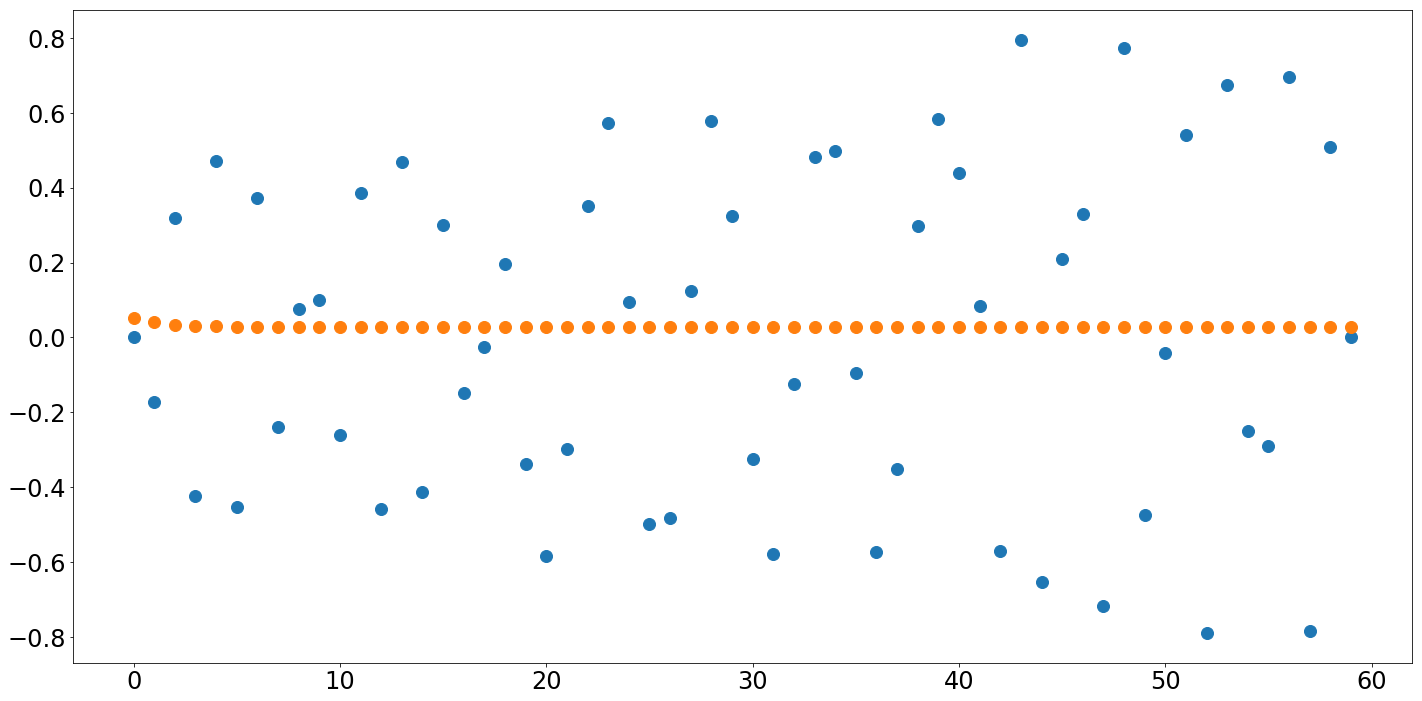

In [25]:
plt.plot(np.reshape(Y.cpu().data.numpy(), [-1]), 'o')
plt.plot(np.reshape(res.cpu().data.numpy(), [-1]), 'o')
plt.show()

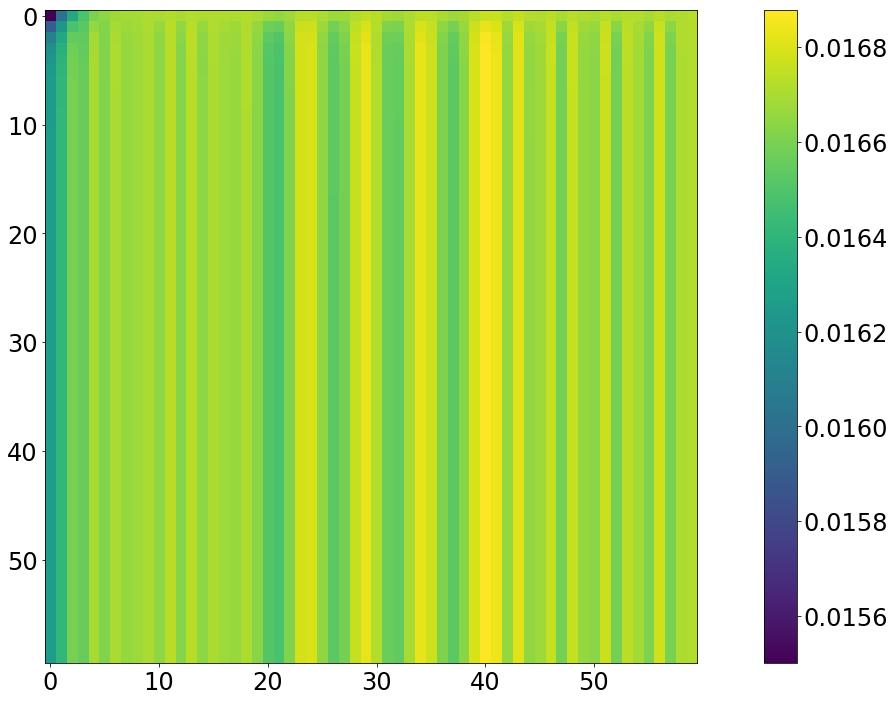

In [26]:
plt.imshow(alphas[0, :, :].cpu().data.numpy())
plt.colorbar()
plt.show()

In [27]:
# !ls -al /tmp/log/

In [28]:
# files.download('/tmp/log/events.out.tfevents.1552339243.84b0ed00c0c0')